In [282]:
%matplotlib inline

import os
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import datetime
import numpy
from pandas.plotting import table 

In [283]:
basic_colors = [
    'b',
'g',
'r',
'c',
'm',
'y',
'k',
'w'
]
colors = [
    'black',
    'rosybrown',
    'brown',
    'red',
    'orangered',
    'lightsalmon',
    'peru',
    'gold',
    'olive',
    'lawngreen',
    'darkgreen',
    'turquoise',
    'teal',
    'slategrey',
    'royalblue',
    'indigo',
    'purple',
    'deeppink'
]

In [284]:
def getDT(dt):
    if isinstance(dt, str):
        return dt
    return dt.strftime("%-m/%-d/%y")
def toDT(dt):
    return datetime.datetime.strptime(dt, "%m/%d/%y")

In [285]:
def getFormattedDfFromTimeSeries(path):
    df = pd.read_csv(path)
    df = df.drop('Lat', 1).drop('Long', 1).drop('Province/State',1)
    df = df.groupby('Country/Region').sum().sort_values(by=df.columns[-1], ascending=False).T
    if 'Cruise Ship' in df.columns:
        df = df.drop('Cruise Ship', 1)
    sortedDf = df.T.sort_values(by=df.T.columns[-1], ascending=False).T
    return sortedDf, pd.read_csv(path).drop('Lat', 1).drop('Long', 1)

In [286]:
careBeds = pd.read_csv("~/Downloads/CareBeds.csv") 
# https://link.springer.com/article/10.1007/s00134-012-2627-8/tables/2

In [287]:
population = pd.read_csv('~/Downloads/PopulationByCountry.csv')
population['Population'] = population['Population'].str.replace(",","").astype(int)
population.loc[population['Name'] == 'United States','Name'] = 'US'
# population.loc[population['Name'] == 'United Kingdom','Name'] = 'UK'

In [288]:
def get_all_data():
    basepath = '../csse_covid_19_data/csse_covid_19_daily_reports/'
    files = filter(lambda x: 'csv' in x, os.listdir(basepath))
    dfs = map(lambda x: pd.read_csv(os.path.join(basepath, x)), files)
    dfs = list(dfs)
    df = pd.concat(dfs, sort=False)
    untransformed = df.copy()
    old_new_cols = {
        'Province/State': 'Province_State',
        'Country/Region': 'Country_Region',
        'Last Update': 'Last_Update',
    }
    for old_col, new_col in old_new_cols.items():
        df[new_col] = df[new_col].fillna(df[old_col])
        df = df.drop(old_col, 1)
    cols_to_drop = ['Lat', 'Long_', 'Latitude', 'Longitude', 'FIPS', 'Admin2']
    for col in cols_to_drop:
        df = df.drop(col, 1)
    df['Last_Update'] = pd.to_datetime(df['Last_Update'])
    untransformed['Last_Update'] = pd.to_datetime(untransformed['Last_Update'])
    df = df.set_index('Last_Update')
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        df[col] = df[col].fillna(0)
#     df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
    df['Province_State'] = df['Province_State'].fillna("All")
    return df.sort_index(), untransformed

In [289]:
all_data, untransformed = get_all_data()

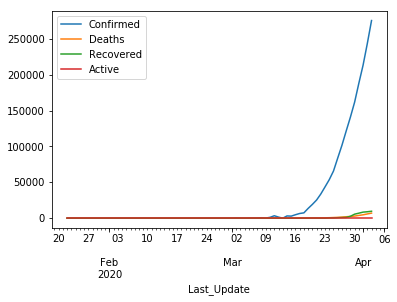

In [290]:
all_us_data = all_data[all_data['Country_Region'] == 'US']
grouped_data = all_us_data.drop('Province_State', 1).drop('Country_Region', 1).reset_index().resample('D', on='Last_Update').sum()
grouped_data.plot()


In [291]:
def getStateData(df, stateName):
    return df[df['Province_State'] == stateName].reset_index().resample('D', on='Last_Update').sum().dropna()


In [ ]:
ny_data = getStateData(all_data, "New York")[4:]

In [307]:
louisiana_data = getStateData(all_data, "Louisiana")[4:]

In [293]:
df_confirmed, df_confirmed_all = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_dead, df_dead_all = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_recovered, df_recovered_all = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


In [294]:
startdatetime = df_confirmed.index[0]
today = df_confirmed.index[-1]

In [295]:
df_active = df_confirmed.copy()
for col in df_confirmed.columns:
    df_active[col] = df_confirmed[col] - df_dead[col] - df_recovered[col]
df_active_all = df_confirmed_all.copy()
for col in df_confirmed_all.drop('Province/State', 1).drop('Country/Region',1).columns:
    df_active_all[col] = df_confirmed_all[col] - df_dead_all[col] - df_recovered_all[col]

In [296]:
mapping = {
    'Iran (Islamic Republic of)': 'Iran',
    'Korea, South': 'South Korea',
    'Russian Federation': 'Russia',
    'occupied Palestinian territory': 'Palestine',
    'Republic of Moldova': 'Moldova',
    'Macao SAR': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Saint Martin': 'St. Martin',
    'Taipei and environs': 'Taiwan',
    'Holy See': 'Vatican City',
    'Viet Nam': 'Vietnam',
}

#Mainland China

for countryName, oldCountryName in mapping.items():
    if oldCountryName in df_confirmed.columns and countryName in df_confirmed.columns:
        df_confirmed[countryName] += df_confirmed[oldCountryName]
        df_confirmed = df_confirmed.drop(oldCountryName, 1)
        
        df_death[countryName] += df_death[oldCountryName]
        df_death = df_death.drop(oldCountryName, 1)
        
        df_recovered[countryName] += df_recovered[oldCountryName]
        df_recovered = df_recovered.drop(oldCountryName, 1)
    
    if oldCountryName in population['Name'].values:
        population.loc[population['Name']==oldCountryName,'Name'] = countryName

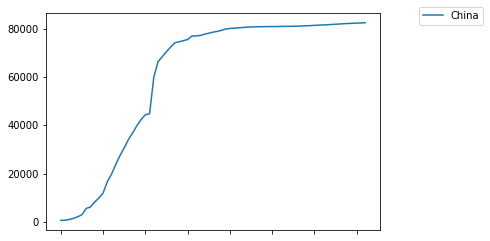

In [297]:
china = df_confirmed['China']
ax = china.plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

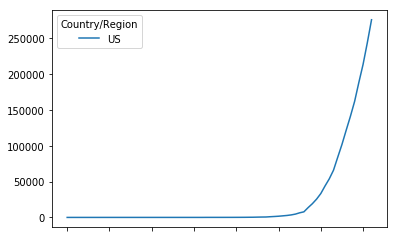

In [298]:
US = df_confirmed[['US']]
US.plot()

In [299]:
def generateAndPlotPrediction(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return lambda t: popt[0] * numpy.exp(popt[1] * t)
def generateAndPlotPredictionEstimates(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return popt

In [397]:
def addToAx(df, ax, dataFor, moredays=0, withFit=True, fromCaseNum=0, color='b'):
    df_from_case_num = df[df > fromCaseNum]
    x = np.linspace(1, len(df_from_case_num), len(df_from_case_num))
    y = df_from_case_num.values
    f = generateAndPlotPrediction(x, y)
    x2 = np.linspace(1, len(df_from_case_num) + moredays, len(df_from_case_num) + moredays)
    ax.plot(x, y, color + '-', label='data for {}'.format(dataFor))
    if withFit:
        print(dataFor, np.ceil(f(x2))[-1])
        ax.plot(x2, np.ceil(f(x2)), color + '--', label='fit for {}'.format(dataFor))
def plotCountries(df, start, end, savefilename='', moredays=0, logy=False, titlePH='confirmed', withFit=True, fromCaseNum=0):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, countryName in enumerate(df.T[start:end].T.columns):
        if countryName == 'Others':
            continue
        addToAx(df[countryName], ax, countryName, moredays=moredays, withFit=withFit, fromCaseNum=fromCaseNum, color=basic_colors[i])
    if moredays > 0:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases -- {} day prediction'.format(titlePH, fromCaseNum, moredays))
    else:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases'.format(titlePH, fromCaseNum))

    if logy:
        ax.set_yscale('log')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename, bbox_extra_artists=(lgd,), bbox_inches='tight')
def plotState(df, stateName, savefig='', moredays=0, withFit=True, fromCaseNum=0, logy=False):
    stateDf = df[
        df['Province/State'].str.contains(stateName)
    ].set_index('Province/State').T.sum(axis=1).T
    fig = plt.figure()
    ax = plt.subplot(111)
    addToAx(
        stateDf, 
        ax,
        stateName,
        moredays=moredays, 
        withFit=withFit, 
        fromCaseNum=fromCaseNum, 
        color=basic_colors[1]
    )
    if logy:
        ax.set_yscale('log')
    plt.title("{} Infected Num".format(stateName))
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig, bbox_inches='tight')
def plotAllDataState(df, savefig='', moredays=0, withFit=True, fromCaseNum=0, logy=False):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, col in enumerate(["Confirmed", "Deaths"]):
        addToAx(
            df[col],
            ax,
            col,
            moredays=moredays, 
            withFit=withFit, 
            fromCaseNum=fromCaseNum, 
            color=basic_colors[i]
        )
    if logy:
        ax.set_yscale('log')
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig, bbox_inches='tight')
def plotCountryDelta(df, countryName, nDaysRolling=3, logy=False, savefilename=None):
    df = df[[countryName]]
    df.loc[:,'delta'] = df[countryName].diff()
    df['secondDiv'] = df['delta'].diff()
    df['derivIncreaseDecrease'] = df['delta'] / df['delta'].shift()
#     df['secondDerivIncreaseDecrease'] = df['secondDiv'] / df['secondDiv'].shift()
    df = df.iloc[2:]
    fig, ax = plt.subplots()
    to_plot = df
    try:
        to_plot.index = map(toDT, to_plot.index)
    except:
        pass
    to_plot[[countryName]].plot(ax=ax)
    to_plot.delta.rolling(nDaysRolling).mean().iloc[nDaysRolling:].plot(ax=ax)
    to_plot.secondDiv.rolling(nDaysRolling).mean().iloc[nDaysRolling:].plot(ax=ax)
    to_plot.derivIncreaseDecrease.plot(ax=ax, secondary_y=True, style='r--')
#     to_plot.secondDerivIncreaseDecrease.plot(ax=ax, secondary_y=True, style='k--')
    if logy:
        ax.set_yscale('log')
        
    # Shrink current axis by 30%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

    ax.set_ylabel('Number')
    ax.right_ax.set_ylabel('Increasing Or Decreasing Deriv')
    fig.get_axes()[1].set_ylim(0.8, 2.5)
    
    # Put a legend to the right of the current axis
    lines = ax.get_lines() + ax.right_ax.get_lines()
    lgd = ax.legend(lines, [l.get_label() for l in lines], loc='center left', bbox_to_anchor=(1.15, 0.5))
    plt.title('Plotting Change For ' + countryName)
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename, bbox_extra_artists=(lgd,), bbox_inches='tight')
        


In [270]:
df_from_case_num = df[df > fromCaseNum]
x = np.linspace(1, len(df_from_case_num), len(df_from_case_num))
y = df_from_case_num.values
f = generateAndPlotPrediction(x, y)
x2 = np.linspace(1, len(df_from_case_num) + moredays, len(df_from_case_num) + moredays)
ax.plot(x, y, color + '-', label='data for {}'.format(dataFor))
if withFit:
    ax.plot(x2, np.ceil(f(x2)), color + '--', label='fit for {}'.format(dataFor))

NameError: name 'fromCaseNum' is not defined

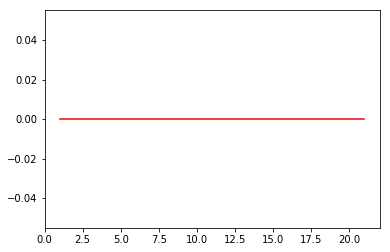

In [301]:
fig = plt.figure()
ax = plt.subplot(111)
df = ny_data[ny_data.columns[2]]
x = np.linspace(1, len(df), len(df))
y = df.values
f = generateAndPlotPrediction(x, y)
x2 = np.linspace(1, len(df) + 0, len(df) + 0)
ax.plot(x, y, "r" + '-', label='data for {}'.format("dataFor"))
plt.show()

In [329]:
def plot_state2(stateName, savefig=''):
    state_data = getStateData(all_data, stateName)[4:]
    state_data_to_plot = state_data[['Confirmed', 'Deaths']]
    state_data_to_plot.loc[:, 'delta_confirmed'] = state_data_to_plot['Confirmed'] - state_data_to_plot['Confirmed'].shift()
    state_data_to_plot.loc[:, 'delta_deaths'] = state_data_to_plot['Deaths'] - state_data_to_plot['Deaths'].shift()
    state_data_to_plot = state_data_to_plot.iloc[1:]
    state_data_to_plot.loc[:, 'doubling_confirmed_days'] = np.log(2)/np.log(1+state_data_to_plot['delta_confirmed']/(state_data_to_plot['Confirmed'] - state_data_to_plot['delta_confirmed']))
    state_data_to_plot.loc[:, 'doubling_deaths_days'] = np.log(2)/np.log(1+state_data_to_plot['delta_deaths']/(state_data_to_plot['Deaths'] - state_data_to_plot['delta_deaths']))
    plotting = state_data_to_plot[['doubling_confirmed_days', 'doubling_deaths_days']]
    print(plotting.iloc[-1], "\n", plotting.iloc[-7])
    plotting.rolling(3).mean().plot()
    plt.title(stateName + ' Expected Days To Double')
    if savefig:
        plt.savefig(savefig + ".png")


doubling_confirmed_days    6.458138
doubling_deaths_days       3.261064
Name: 2020-04-03 00:00:00, dtype: float64 
 doubling_confirmed_days    4.466319
doubling_deaths_days       2.145299
Name: 2020-03-28 00:00:00, dtype: float64


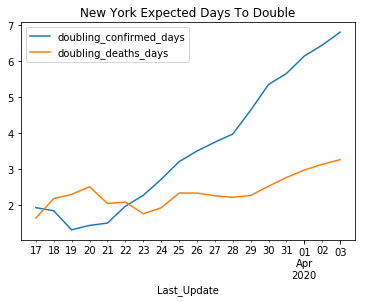

In [333]:
plot_state2("New York")

Confirmed 270640.0
Deaths 12868.0


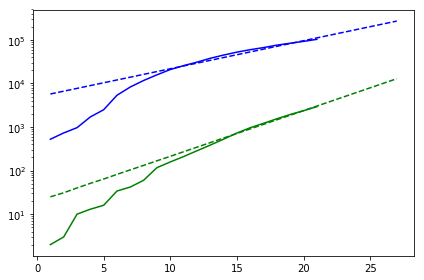

In [336]:
plotAllDataState(ny_data, moredays=6, logy=True)

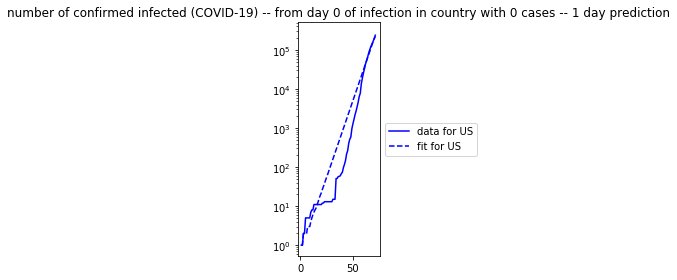

In [45]:
plotCountries(df_confirmed.T.iloc[[0]].T, 0, 1, moredays=1, logy=True)

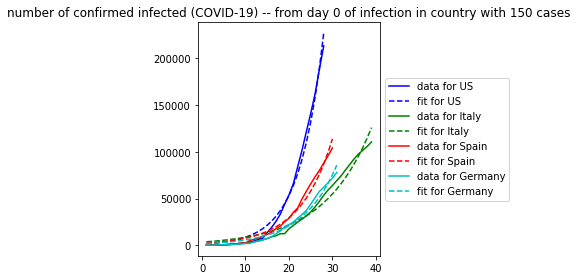

In [49]:
plotCountries(df_confirmed.T.iloc[[0, 1, 2, 4, 5]].T, 0, 4, 
              'Italy.Germany.US.Spain.png',
              moredays=0, 
              logy=False, 
              fromCaseNum=150)

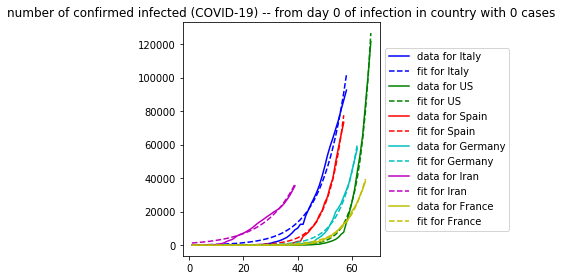

In [1579]:
plotCountries(df_confirmed, 1,7, logy=False, fromCaseNum=0)

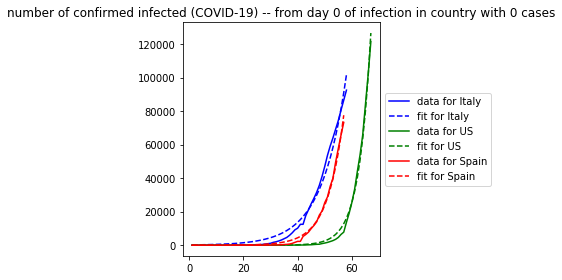

In [1580]:
plotCountries(df_confirmed, 1,4, 'SK.Iran.Italy.png',moredays=0)

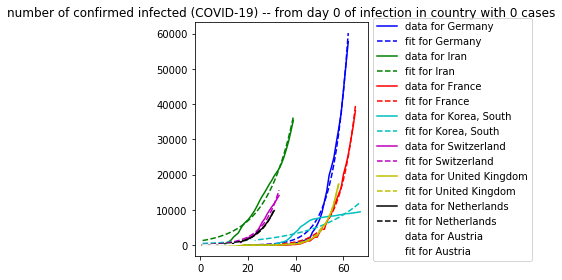

In [1581]:
plotCountries(df_confirmed, 4,len(basic_colors) + 4, '4.11.png', moredays=0)

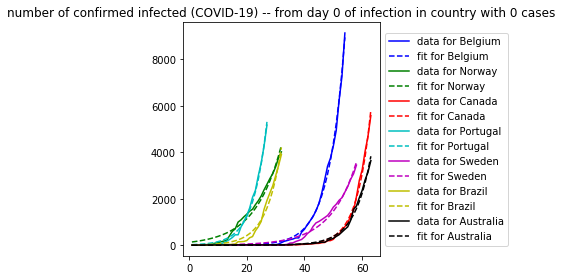

In [1582]:
plotCountries(df_confirmed, len(basic_colors) + 4, 2*len(basic_colors) + 3, '12.18.png', moredays=0)

In [50]:
US_all_confirmed = df_confirmed_all[df_confirmed_all['Country/Region'] == 'US']
US_all_confirmed = US_all_confirmed.drop('Country/Region', 1)

US_all_dead = df_dead_all[df_confirmed_all['Country/Region'] == 'US']
US_all_dead = US_all_dead.drop('Country/Region', 1)

US_all_active = df_active_all[df_confirmed_all['Country/Region'] == 'US']
US_all_active = US_all_active.drop('Country/Region', 1)

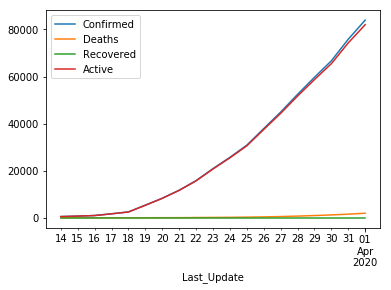

In [95]:
ny_data.plot()

In [51]:
plotState(US_all_active, stateName='California', savefig='CA.png')

ValueError: cannot index with vector containing NA / NaN values

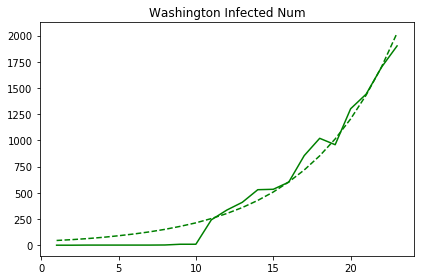

In [1337]:
plotState(US_all_active, 'Washington', 'WA.png')

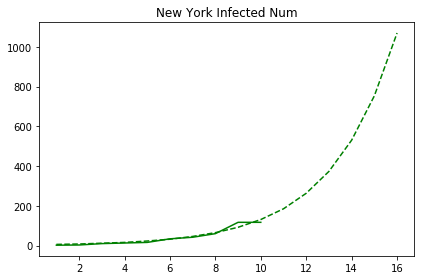

In [1474]:
plotState(US_all_dead.iloc[:-3], 'New York','NY.png',logy=False, moredays=6)

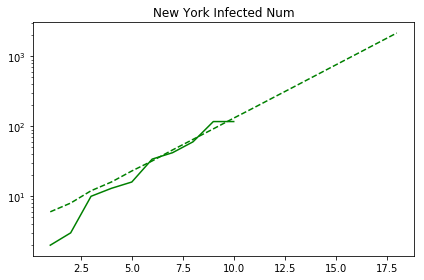

In [1480]:
plotState(US_all_dead.T.iloc[:-30], 'New York','NY.dead.png',logy=True, moredays=8)

In [339]:
dfByPop = pd.merge(df_active.iloc[-1:].T.reset_index().rename(columns={'Country/Region':'Name'}), population, on='Name')
dfByPop = dfByPop.rename(columns={getDT(today):'InfectedNum'})
# dfByPop['Population'] = dfByPop['Population'].str.replace(",","").astype(int)
dfByPop['1 in X'] = (dfByPop['Population'] / dfByPop['InfectedNum']).replace([np.inf, -np.inf], np.nan).dropna(how="all").astype(int)
dfByPop['% Have It'] = (100 * dfByPop['InfectedNum'] / dfByPop['Population']).round(4)

success
              Name  InfectedNum  1 in X
0            Spain        77488     603
1      Switzerland        14169     610
2            Italy        85388     708
3          Belgium        12755     908
4          Austria         9334     964
5           Norway         5279    1026
6         Portugal         9572    1065
7      Netherlands        14071    1217
8           Israel         6985    1239
9               US       258792    1279
10         Germany        65309    1282
11          France        44547    1465
12          Sweden         5568    1813
13  United Kingdom        34870    1946
14         Denmark         2520    2298
15          Canada        10083    3743
16          Turkey        20012    4214
17         Finland         1295    4278
18       Australia         4653    5480
19         Ecuador         3158    5586
20           Chile         3288    5813
21          Serbia         1437    6080
22         Romania         2767    6952
23       Singapore          827 

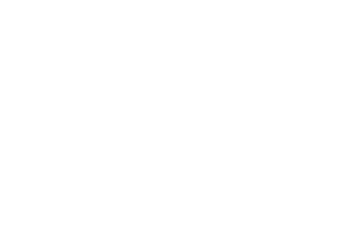

In [340]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tableToPlot = dfByPop[dfByPop['Population'] > 5000000].sort_values(by='1 in X').reset_index()[['Name', 'InfectedNum', '1 in X']]

tableToPlot[:25].to_html('table.tmp.html')
title = """<h3>Active Cases By Country, 1 In X people currently have it</h3>"""
with open('table.tmp.html', 'r') as f:
    with open('table.html', 'w') as f2:
        f2.write(title + "\n")
        f2.write(f.read())
import subprocess
output = subprocess.call(
    'wkhtmltoimage -f png --width 0 table.html table.activebycountry.1inx.wkh.png', shell=True)

if output != 0:
    print("Try installing wkhtmltoimage/pdf: brew cask install wkhtmltopdf")
else:
    subprocess.call('rm *.html', shell=True)
    print("success")
    print(tableToPlot[:25])

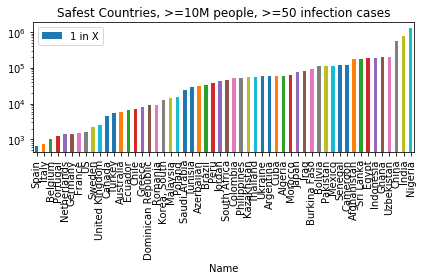

In [212]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].plot.bar(x='Name', y='1 in X',logy=True)
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.1inx.png', bbox_inches='tight')

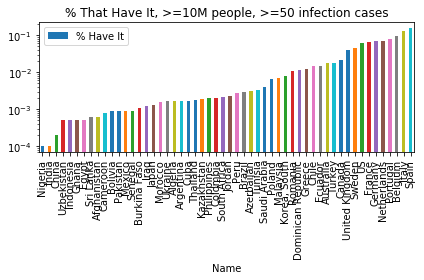

In [213]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='% Have It')
toPlot[['Name', '% Have It']].plot.bar(x='Name', y='% Have It',logy=True)
plt.title('% That Have It, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.percenthaveit.png', bbox_inches='tight')

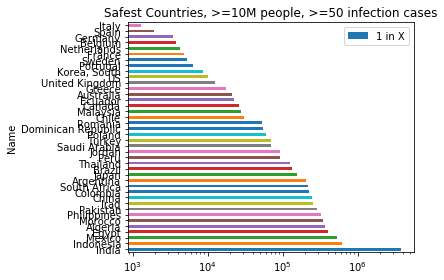

In [1344]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].iloc[::-1].plot(kind='barh', x='Name', y='1 in X', logx=True)
ax.invert_xaxis()
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.2.png')

In [341]:
notChina = df_confirmed.drop('China', 1)
notChina = pd.DataFrame(data=notChina.sum(axis=1).values, columns=['NumInfected'], index=notChina.index)
notChina['delta'] = notChina.diff(axis=0)
notChina = notChina.iloc[1:]
notChina['secondDiv'] = notChina['delta'] / notChina['delta'].shift()
notChina = notChina.iloc[1:]

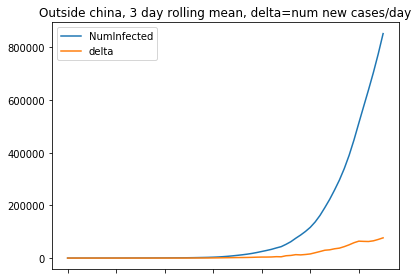

In [342]:
notChina[['NumInfected','delta']].rolling(3).mean().iloc[4:-1].plot()
plt.title("Outside china, 3 day rolling mean, delta=num new cases/day")
plt.tight_layout()
plt.savefig("outsidechina.firstderiv.png")

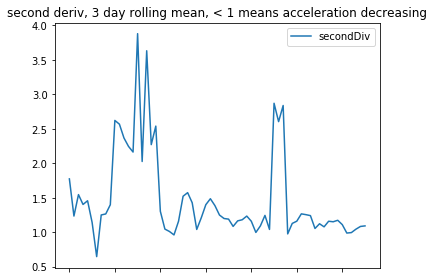

In [343]:
notChina[['secondDiv']].rolling(3).mean().iloc[4:-1].plot()
plt.title("second deriv, 3 day rolling mean, < 1 means acceleration decreasing")
plt.tight_layout()
# plt.savefig("outsidechina.secondderiv.png")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


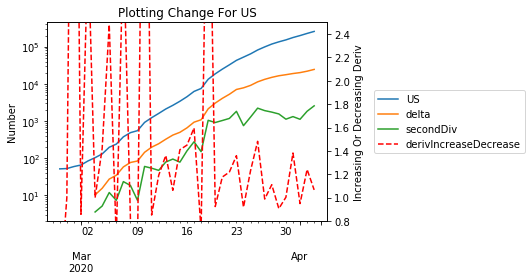

In [379]:
plotCountryDelta(df_active.iloc[34:], 'US', logy=True, nDaysRolling=5, savefilename='USChange.png')

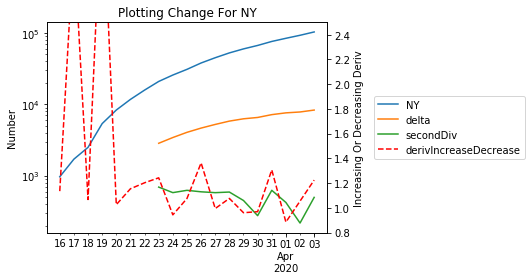

In [399]:
tmp = df_active.copy() # ny_data['Confirmed']
tmp = tmp.join(ny_data['Confirmed'])[['Confirmed']].dropna().rename(columns={'Confirmed':'NY'})
plotCountryDelta(tmp, 'NY', logy=True, nDaysRolling=7)#, #savefilename='USChange.png')

In [218]:
def predictForwardFromOthers(df, currentVal, inHowManyDays):
    avgT = 0
    avgC = 0
    for countryName in df.iloc[-1:][df.iloc[-1:] > currentVal].dropna(1).columns:
        if 'China' in countryName:
            continue
        previousValue = sum(df[countryName] > currentVal) + 1
        dfIncluding = df[countryName][-previousValue:]
        if (previousValue - 1) < inHowManyDays:
            continue
        previous, nextVal = dfIncluding.iloc[0], dfIncluding.iloc[inHowManyDays]
        avgT += (1 - (currentVal - previous)/currentVal) * (nextVal - currentVal)
        avgC += 1
    return avgT/avgC + currentVal, avgC

In [229]:
predictForwardFromOthers(df_dead, 2200, 4) # new york numbe rof cases

(3704.0183636363636, 5)

In [1218]:
predictForwardFromOthers(df_confirmed, 328, 4)

(767.5867729831144, 26)

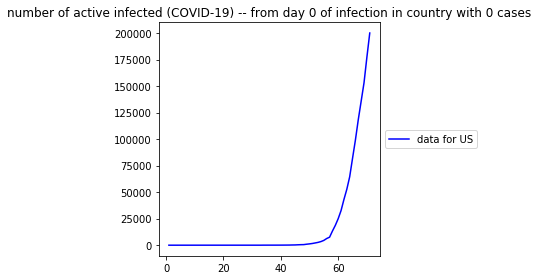

In [230]:
plotCountries(df_active, 0, 1, titlePH='active',withFit=False, savefilename='activeCasesChina.png')

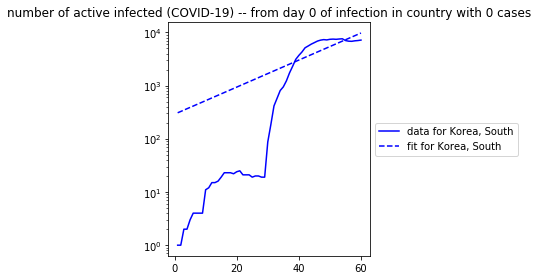

In [1220]:
plotCountries(df_active, 7, 8, titlePH='active',withFit=True, logy=True, savefilename='us_active_logy.png')

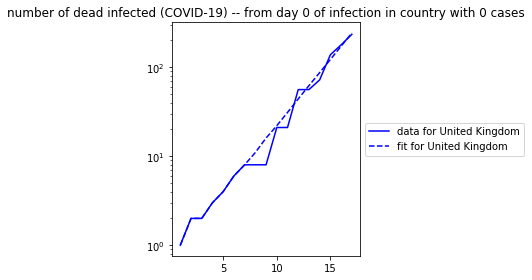

In [1221]:
plotCountries(df_dead, 6, 7, titlePH='dead',withFit=True, logy=True, savefilename='us_dead_logy.png')

In [239]:
def plotStackedLine(df, title, numberOfCountries, savefigName=''):
    percentActiveDf =  df.div(df.sum(1), axis=0)
    plottingDf = percentActiveDf.T.sort_values(by=df_active.index[-1],ascending=False).iloc[:numberOfCountries].T
    if 'China' not in plottingDf:
        plottingDf['China'] = percentActiveDf['China']
    plottingDf['Other'] = 1 - plottingDf.sum(axis=1)
    plottingDf.index = list(map(toDT, plottingDf.index))

    ax = plottingDf.plot.area()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.title(title)

    if savefigName:
        plt.savefig(savefigName, bbox_extra_artists=(lgd,), bbox_inches='tight')

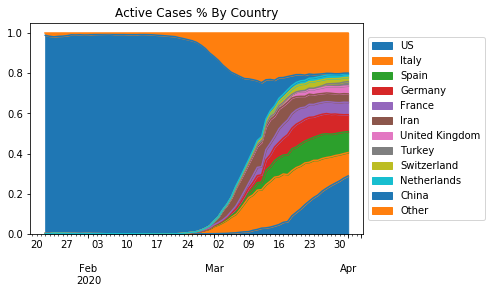

In [241]:
plotStackedLine(df_active, 'Active Cases % By Country', 10, 'stackedarea.active.all.png')

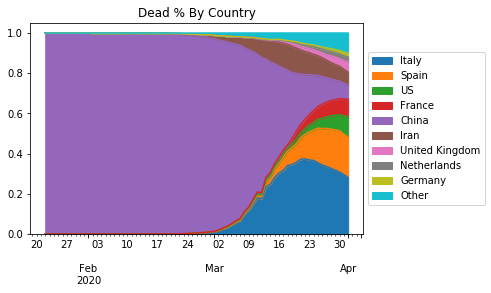

In [242]:
plotStackedLine(df_dead, 'Dead % By Country', 9, 'stackedarea.dead.all.png')

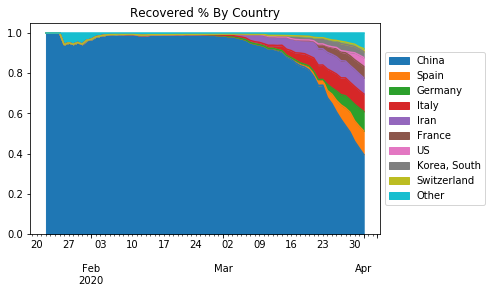

In [243]:
plotStackedLine(df_recovered, 'Recovered % By Country', 9, 'stackedarea.recovered.all.png')

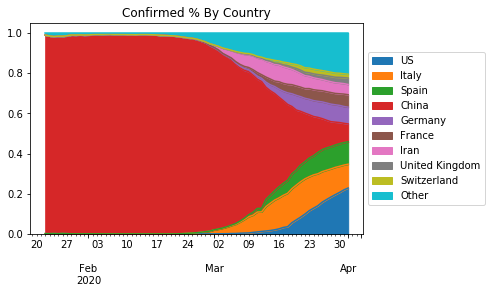

In [244]:
plotStackedLine(df_confirmed, 'Confirmed % By Country', 9, 'stackedarea.recovered.all.png')

In [1420]:
italy = df_dead[['Italy']].rename(columns={'Italy':'Cum Num Dead'})
italy['new_dead'] = italy['Cum Num Dead'] - italy['Cum Num Dead'].shift(1)
italy['dead_per_minute'] = (24 * 60) / italy['new_dead']
italy = italy.iloc[1:].replace(np.inf, 0)

There is one death per 132.7188940092166 seconds in the Italy right now


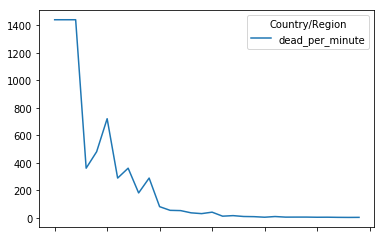

In [1425]:
print("There is one death per {} seconds in the Italy right now".format(italy['dead_per_minute'].iloc[-1] * 60))
italy[['dead_per_minute']][italy['dead_per_minute']!=0].plot()

In [1426]:
lastTwoDaysDeaths = df_dead.sum(axis=1).iloc[-2:]
secondsPerDeaths = int((24*60*60)/(lastTwoDaysDeaths.iloc[-1] - lastTwoDaysDeaths.iloc[0]))
print("There is one death per {} seconds in the world right now".format(secondsPerDeaths))

There is one death per 52 seconds in the world right now


In [1427]:
def combineCountry(df_dead, df_confirmed, df_active, df_recovered, countryName):
    if df_dead is not None:
        df_dead = df_dead[[countryName]].rename(columns={countryName:countryName + " Dead"})
    if df_confirmed is not None:
        df_confirmed = df_confirmed[[countryName]].rename(columns={countryName:countryName + " Confirmed"})
    if df_active is not None:
        df_active = df_active[[countryName]].rename(columns={countryName:countryName + " Active"})
    if df_recovered is not None:
        df_recovered = df_recovered[[countryName]].rename(columns={countryName:countryName + " Recovered"})    
    
    dfs = list(filter(lambda x: x is not None, [df_dead, df_confirmed, df_active, df_recovered]))
    if len(dfs) == 0:
        return None
    df = dfs[0]
    for df2 in dfs[1:]:
        df = df.join(df2)
    return df

In [1428]:
def plotCountriesTotal(df_dead, df_confirmed, df_active, df_recovered, countryNames):
    fig = plt.figure()
    ax = plt.subplot(111)
    for countryName in countryNames:
        df = combineCountry(df_dead, df_confirmed, df_active, df_recovered, countryName)
        df.index = list(map(toDT, df.index))
        df.plot(ax=ax)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.title(" - ".join(countryNames))
    plt.savefig(".".join(countryNames) + ".all.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

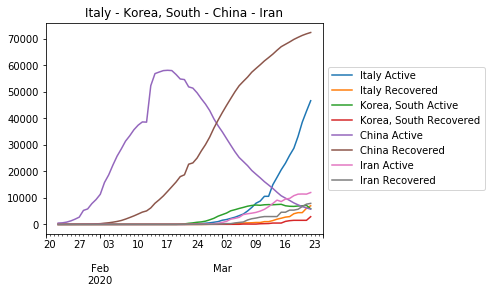

In [1429]:
plotCountriesTotal(None, None, df_active, df_recovered, ["Italy", "Korea, South", "China", "Iran"])

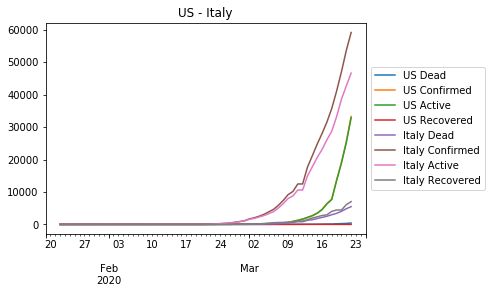

In [1430]:
plotCountriesTotal(df_dead, df_confirmed, df_active, df_recovered, ["US", "Italy"])

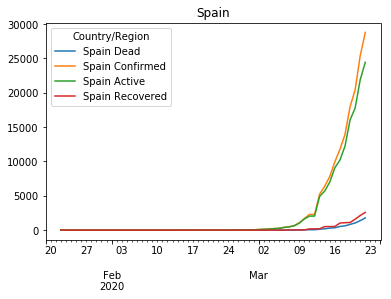

In [1431]:
plotCountryTotal(df_dead, df_confirmed, df_active, df_recovered, "Spain")

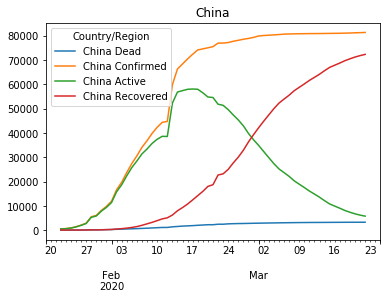

In [1432]:
plotCountryTotal(df_dead, df_confirmed, df_active, df_recovered, "China")

In [245]:
# https://link.springer.com/article/10.1007/s00134-012-2627-8/tables/2
ICUBeds = {
    "US": 34.2,
    "Germany": 29.2,
    "Italy": 12.5,
    "France": 11.6,
    "Korea, South": 10.6,
    "Spain": 9.7,
    "Japan": 7.3,
    "United Kingdom": 6.6,
    "China": 3.6,
    "India": 2.3,
    "Iran": 7.29,
    "Switzerland": 11.0,
    "Netherlands": 6.4,
    "Norway": 8.0,
    "Sweden": 5.8,
    "Belgium": 15.9,
    "Austria": 21.8,
    "Denmark": 6.7,
    "Andorra": 7.1,
    "Bulgaria": 12.2,
    
}
icuBeds = pd.DataFrame(data=[ICUBeds]).T.rename(columns={0:'ICU Beds Per 100k'})

In [246]:
todayDead = df_dead.iloc[[-1]].T.rename(columns={today:"dead"})
todayConfirmed = df_confirmed.iloc[[-1]].T.rename(columns={today:"confirmed"})
todayRecovered = df_recovered.iloc[[-1]].T.rename(columns={today:"recovered"})
df = todayDead.join(todayConfirmed).join(todayRecovered)
df['death_rate'] = (100 * df['dead'] / df['confirmed']).round(2)
df['recover_rate'] = (100 * df['recovered'] / df['confirmed']).round(2)
df = df.join(careBeds.set_index("Country")[["ICU Beds Per 100k"]])

In [247]:
def scatterPlotICU(df, yaxis):
    toPlot = df.dropna().iloc[:len(colors)]
    toPlot['color'] = colors
    fig = plt.figure(figsize=(8,8),dpi=75)
    ax = fig.gca()
    ax.scatter(toPlot[yaxis],toPlot['ICU Beds Per 100k'],c=toPlot["color"],alpha=0.4)
    ax.set_xlabel(yaxis)
    ax.set_ylabel("ICU Beds Per 100k")

    col_dict = toPlot[['color']].to_dict()['color']

    #retrieve values from color dictionary and attribute it to corresponding labels
    leg_el = [
        mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) 
        for key, value in col_dict.items()
    ]
    lgd = ax.legend(handles = leg_el)
    plt.title("ICU Beds Versus " + yaxis)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    plt.tight_layout()
    plt.savefig("icu."+yaxis+".png", bbox_extra_artists=(lgd,), bbox_inches='tight')

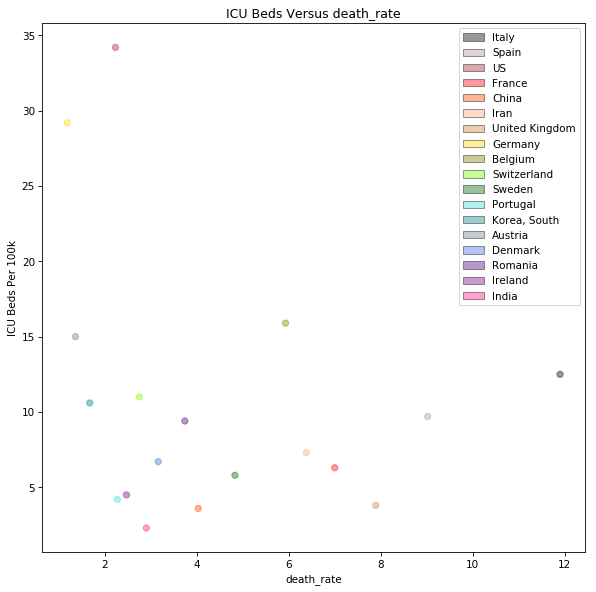

In [248]:
scatterPlotICU(df, "death_rate")

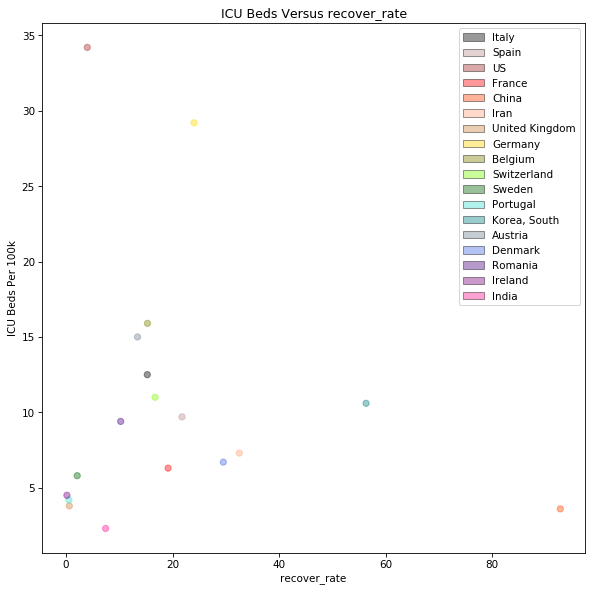

In [249]:
scatterPlotICU(df, "recover_rate")